# MLP on the MNIST Dataset

Trains four simple NNs with 3 hidden layers on the MNIST dataset. (5 runs, seed = 10, 20, 30, 40, 50)

1. 784-2048-784-2048-10 (Res Connect; MSE; lr = 0.05): validation accuracies: 0.9545, 0.9543, 0.9526, 0.9527, 0.9533

2. 784-2048-2048-2048-10 (MLP; MSE; lr = 0.05): validation accuracies: 0.9545, 0.9543, 0.9526, 0.9527, 0.9533

3. 784-2048-784-2048-10 (Res Connect; hinge loss; lr = 0.01): validation accuracies: 0.9818, 0.9872, 0.9812, 0.9818, 0.9814

4. 784-2048-2048-2048-10 (MLP; hinge loss; lr = 0.05): validation accuracies: 0.9819, 0.9775, 0.9832, 0.9821, 0.981

~1 seconds per epoch on 4 GTX1080 Ti GPU, ~2 seconds per epoch on a GTX1070 GPU.


## Import Tensorflow package (for Keras) and Reproducibility

In [1]:
from __future__ import print_function

import numpy as np
import tensorflow as tf
import random as rn

import os
os.environ['PYTHONHASHSEED'] = '0'

seed = 50

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(seed)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(seed)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=4)

# from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(seed)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
tf.keras.backend.set_session(sess)

## Import the MNIST dataset

In [2]:
batch_size = 512
num_classes = 10
epochs = 100

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

60000 train samples
10000 test samples


## Visualize Some Training Samples

The first 5 images, followed by 25 random images:


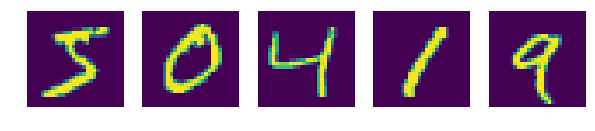

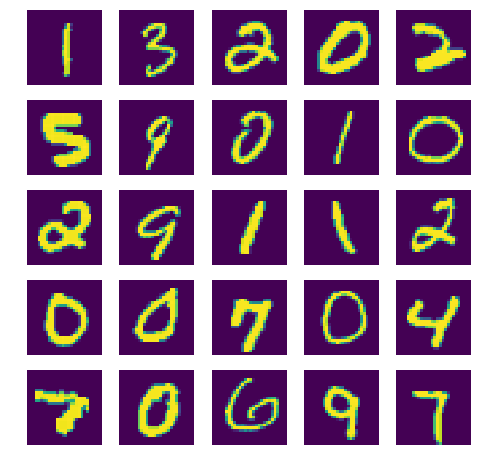

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(1,5,figsize=(10,10))
print('The first 5 images, followed by 25 random images:')
for i in range(5):
    axes[i].set_axis_off()
    axes[i].imshow(x_train[i], interpolation='nearest')

fig1, axes1 = plt.subplots(5,5,figsize=(8,8))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(x_train)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(x_train[i:i+1][0], interpolation='nearest')

## Data Transformation

In [4]:
x_train = x_train.reshape((60000, 784), order='F') # reshaping order fixed to the same as BCD
x_test = x_test.reshape((10000, 784), order='F') # reshaping order fixed to the same as BCD
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

60000 train samples
10000 test samples


# The First Model (Residual Connection) (MSE)

## Model Setup

Input -> Fully Connected (2048) -> ReLU -> Fully Connected (784) -> Add Input -> ReLU -> Fully Connected (2048) -> ReLU -> Fully Connected (10) -> Mean squared loss

In [5]:
# model
x1 = tf.keras.layers.Input(shape=(784,))
a1 = tf.keras.layers.Dense(2048, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(x1)
a2 = tf.keras.layers.Dense(784, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(a1)
a2 = tf.keras.layers.Add()([a2, x1])
a3 = tf.keras.layers.Dense(2048, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(a2)
y_mlp = tf.keras.layers.Dense(num_classes, activation=None, use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(a3)
#y_mlp = tf.keras.layers.Dense(num_classes, activation='softmax', use_bias=True, kernel_regularizer=tf.keras.regularizers.l2(l=0.01))(a3)

model = tf.keras.models.Model(inputs=x1, outputs=y_mlp)

model.summary()

sgd1 = tf.keras.optimizers.SGD(lr=0.05, decay=0, momentum=0, nesterov=False)
model.compile(loss='mean_squared_error', optimizer=sgd1, metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2048)         1607680     input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 784)          1606416     dense_1[0][0]                    
__________________________________________________________________________________________________
add_1 (Add)                     (None, 784)          0           dense_2[0][0]                    
                                                                 input_1[0][0]                    
__________

## Fit the Model using Back Propagation (Vanilla SGD)

In [6]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    validation_data=(x_test, y_test),
                    shuffle=False)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
#print('Test error:', 1-score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
 - 2s - loss: 0.0688 - acc: 0.6490 - val_loss: 0.0559 - val_acc: 0.7910
Epoch 2/100
 - 1s - loss: 0.0516 - acc: 0.7932 - val_loss: 0.0482 - val_acc: 0.8185
Epoch 3/100
 - 1s - loss: 0.0466 - acc: 0.8190 - val_loss: 0.0447 - val_acc: 0.8353
Epoch 4/100
 - 1s - loss: 0.0440 - acc: 0.8335 - val_loss: 0.0426 - val_acc: 0.8453
Epoch 5/100
 - 1s - loss: 0.0422 - acc: 0.8438 - val_loss: 0.0411 - val_acc: 0.8537
Epoch 6/100
 - 1s - loss: 0.0409 - acc: 0.8513 - val_loss: 0.0399 - val_acc: 0.8595
Epoch 7/100
 - 1s - loss: 0.0398 - acc: 0.8569 - val_loss: 0.0388 - val_acc: 0.8644
Epoch 8/100
 - 1s - loss: 0.0388 - acc: 0.8612 - val_loss: 0.0378 - val_acc: 0.8688
Epoch 9/100
 - 1s - loss: 0.0378 - acc: 0.8654 - val_loss: 0.0369 - val_acc: 0.8723
Epoch 10/100
 - 1s - loss: 0.0369 - acc: 0.8686 - val_loss: 0.0360 - val_acc: 0.8764
Epoch 11/100
 - 1s - loss: 0.0361 - acc: 0.8722 - val_loss: 0.0352 - val_acc: 0.8794
Epoch 12/100
 - 1s - los

Epoch 97/100
 - 1s - loss: 0.0138 - acc: 0.9524 - val_loss: 0.0137 - val_acc: 0.9522
Epoch 98/100
 - 1s - loss: 0.0137 - acc: 0.9527 - val_loss: 0.0137 - val_acc: 0.9526
Epoch 99/100
 - 1s - loss: 0.0136 - acc: 0.9531 - val_loss: 0.0136 - val_acc: 0.9530
Epoch 100/100
 - 1s - loss: 0.0136 - acc: 0.9533 - val_loss: 0.0136 - val_acc: 0.9533
Test loss: 0.013560824438929558
Test accuracy: 0.9533


## Loss and Accuracy Plots

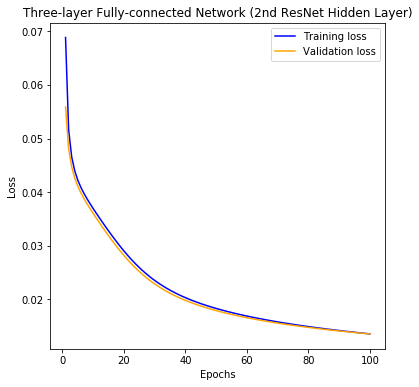

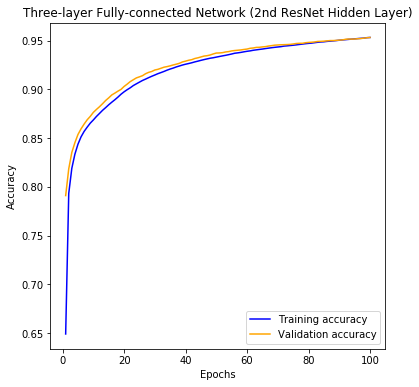

In [7]:
# Plot of Losses
history_dict = history.history
# history_dict.keys()
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

epochs_index = range(1,len(loss_values)+1)

fig_loss = plt.figure(figsize=(6, 6))
plt.plot(epochs_index, loss_values, 'b', label='Training loss')
plt.plot(epochs_index, val_loss_values, 'b', c='orange', label='Validation loss')
plt.title('Three-layer Fully-connected Network (2nd ResNet Hidden Layer)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Plot of Accuracies
fig_accuracy = plt.figure(figsize=(6, 6))
plt.plot(epochs_index,acc_values,'b', label='Training accuracy')
plt.plot(epochs_index,val_acc_values,'b', c='orange', label='Validation accuracy')
plt.title('Three-layer Fully-connected Network (2nd ResNet Hidden Layer)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

## Save the Plots

In [8]:
fig_accuracy.savefig('fig_accuracy.eps', format='eps', dpi=2000)
fig_accuracy.savefig('fig_accuracy.pdf', format='pdf', dpi=2000)

# The Second Model (MLP)

## Model Setup

Input -> Fully Connected (2048) -> ReLU -> Fully Connected (2048) -> ReLU -> Fully Connected (2048) -> ReLU -> Fully Connected (10) -> Mean squared loss

In [9]:
# model
x0 = tf.keras.layers.Input(shape=(784,))
u1 = tf.keras.layers.Dense(2048, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(x0)
u2 = tf.keras.layers.Dense(2048, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(u1)
u3 = tf.keras.layers.Dense(2048, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(u2)
y_mlp_2 = tf.keras.layers.Dense(num_classes, activation=None, use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(u3)
#y_mlp = tf.keras.layers.Dense(num_classes, activation='softmax', use_bias=True, kernel_regularizer=tf.keras.regularizers.l2(l=0.01))(a3)

model_2 = tf.keras.models.Model(inputs=x0, outputs=y_mlp_2)

model_2.summary()

sgd2 = tf.keras.optimizers.SGD(lr=0.05, decay=0, momentum=0, nesterov=False)
model_2.compile(loss='mean_squared_error', optimizer=sgd2, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              1607680   
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_7 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_8 (Dense)              (None, 10)                20490     
Total params: 10,020,874
Trainable params: 10,020,874
Non-trainable params: 0
_________________________________________________________________


## Fit the Model using Back Propagation (Vanilla SGD)

In [10]:
history_2 = model_2.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    validation_data=(x_test, y_test),
                    shuffle=False)
score_2 = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score_2[0])
print('Test accuracy:', score_2[1])
#print('Test error:', 1-score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
 - 2s - loss: 0.0870 - acc: 0.4261 - val_loss: 0.0838 - val_acc: 0.6937
Epoch 2/100
 - 2s - loss: 0.0808 - acc: 0.6536 - val_loss: 0.0773 - val_acc: 0.7292
Epoch 3/100
 - 2s - loss: 0.0742 - acc: 0.6875 - val_loss: 0.0704 - val_acc: 0.7337
Epoch 4/100
 - 2s - loss: 0.0675 - acc: 0.6999 - val_loss: 0.0641 - val_acc: 0.7365
Epoch 5/100
 - 2s - loss: 0.0619 - acc: 0.7146 - val_loss: 0.0592 - val_acc: 0.7509
Epoch 6/100
 - 2s - loss: 0.0576 - acc: 0.7318 - val_loss: 0.0556 - val_acc: 0.7651
Epoch 7/100
 - 2s - loss: 0.0544 - acc: 0.7488 - val_loss: 0.0528 - val_acc: 0.7786
Epoch 8/100
 - 2s - loss: 0.0519 - acc: 0.7640 - val_loss: 0.0506 - val_acc: 0.7915
Epoch 9/100
 - 2s - loss: 0.0498 - acc: 0.7787 - val_loss: 0.0486 - val_acc: 0.8033
Epoch 10/100
 - 2s - loss: 0.0480 - acc: 0.7906 - val_loss: 0.0470 - val_acc: 0.8129
Epoch 11/100
 - 2s - loss: 0.0466 - acc: 0.8014 - val_loss: 0.0456 - val_acc: 0.8203
Epoch 12/100
 - 2s - los

Epoch 97/100
 - 2s - loss: 0.0142 - acc: 0.9410 - val_loss: 0.0140 - val_acc: 0.9436
Epoch 98/100
 - 2s - loss: 0.0141 - acc: 0.9413 - val_loss: 0.0139 - val_acc: 0.9439
Epoch 99/100
 - 2s - loss: 0.0140 - acc: 0.9419 - val_loss: 0.0138 - val_acc: 0.9442
Epoch 100/100
 - 2s - loss: 0.0139 - acc: 0.9423 - val_loss: 0.0137 - val_acc: 0.9442
Test loss: 0.013560824438929558
Test accuracy: 0.9533


## Loss and Accuracy Plots

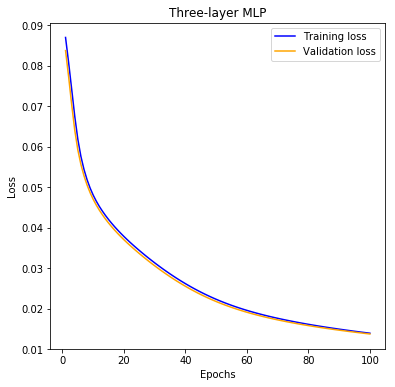

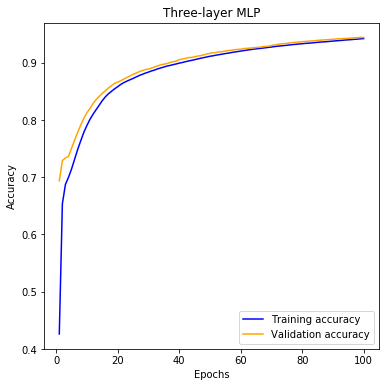

In [11]:
# Plot of Losses
history_dict_2 = history_2.history
loss_values_2 = history_dict_2['loss']
val_loss_values_2 = history_dict_2['val_loss']
acc_values_2 = history_dict_2['acc']
val_acc_values_2 = history_dict_2['val_acc']

epochs_index = range(1,len(loss_values)+1)
fig_loss_2 = plt.figure(figsize=(6, 6))
plt.plot(epochs_index, loss_values_2, 'b', label='Training loss')
plt.plot(epochs_index, val_loss_values_2, 'b', c='orange', label='Validation loss')
plt.title('Three-layer MLP')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Plot of Accuracies
fig_accuracy_2 = plt.figure(figsize=(6, 6))
plt.plot(epochs_index,acc_values_2,'b', label='Training accuracy')
plt.plot(epochs_index,val_acc_values_2,'b', c='orange', label='Validation accuracy')
plt.title('Three-layer MLP')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

## Save the Plots

In [12]:
fig_accuracy_2.savefig('fig_accuracy_2.eps', format='eps', dpi=2000)
fig_accuracy_2.savefig('fig_accuracy_2.pdf', format='pdf', dpi=2000)

# The Third Model (Residual Connection) (Hinge Loss)

Input -> Fully Connected (2048) -> ReLU -> Fully Connected (784) -> Add Input -> ReLU -> Fully Connected (2048) -> ReLU -> Fully Connected (10) -> Softmax -> Categorical hinge loss

In [13]:
# model
z0 = tf.keras.layers.Input(shape=(784,))
z1 = tf.keras.layers.Dense(2048, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(z0)
z2 = tf.keras.layers.Dense(784, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(z1)
z2 = tf.keras.layers.Add()([z2, z0])
z3 = tf.keras.layers.Dense(2048, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(z2)
#y_mlp_2 = tf.keras.layers.Dense(num_classes, activation=None, use_bias=True)(z3)
y_mlp_3 = tf.keras.layers.Dense(num_classes, activation=None, use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(z3)

model_3 = tf.keras.models.Model(inputs=z0, outputs=y_mlp_3)

model_3.summary()

sgd3 = tf.keras.optimizers.SGD(lr=0.05, decay=0, momentum=0, nesterov=False)
model_3.compile(loss='categorical_hinge', optimizer=sgd3, metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 2048)         1607680     input_3[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 784)          1606416     dense_9[0][0]                    
__________________________________________________________________________________________________
add_2 (Add)                     (None, 784)          0           dense_10[0][0]                   
                                                                 input_3[0][0]                    
__________

## Fit the Model using Back Propagation (Vanilla SGD)

In [14]:
history_3 = model_3.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    validation_data=(x_test, y_test),
                    shuffle=False)
score_3 = model_3.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score_3[0])
print('Test accuracy:', score_3[1])
#print('Test error:', 1-score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
 - 1s - loss: 0.6904 - acc: 0.7250 - val_loss: 0.4447 - val_acc: 0.8437
Epoch 2/100
 - 1s - loss: 0.3508 - acc: 0.8811 - val_loss: 0.3109 - val_acc: 0.8878
Epoch 3/100
 - 1s - loss: 0.2767 - acc: 0.8999 - val_loss: 0.2700 - val_acc: 0.8997
Epoch 4/100
 - 1s - loss: 0.2447 - acc: 0.9104 - val_loss: 0.2524 - val_acc: 0.9064
Epoch 5/100
 - 1s - loss: 0.2236 - acc: 0.9178 - val_loss: 0.2306 - val_acc: 0.9158
Epoch 6/100
 - 1s - loss: 0.2076 - acc: 0.9234 - val_loss: 0.2083 - val_acc: 0.9243
Epoch 7/100
 - 1s - loss: 0.1941 - acc: 0.9286 - val_loss: 0.1953 - val_acc: 0.9291
Epoch 8/100
 - 1s - loss: 0.1822 - acc: 0.9332 - val_loss: 0.1839 - val_acc: 0.9340
Epoch 9/100
 - 1s - loss: 0.1718 - acc: 0.9370 - val_loss: 0.1754 - val_acc: 0.9369
Epoch 10/100
 - 1s - loss: 0.1624 - acc: 0.9404 - val_loss: 0.1674 - val_acc: 0.9405
Epoch 11/100
 - 1s - loss: 0.1539 - acc: 0.9443 - val_loss: 0.1608 - val_acc: 0.9425
Epoch 12/100
 - 1s - los

Epoch 97/100
 - 1s - loss: 0.0179 - acc: 0.9937 - val_loss: 0.0528 - val_acc: 0.9815
Epoch 98/100
 - 1s - loss: 0.0176 - acc: 0.9939 - val_loss: 0.0526 - val_acc: 0.9816
Epoch 99/100
 - 1s - loss: 0.0172 - acc: 0.9940 - val_loss: 0.0527 - val_acc: 0.9814
Epoch 100/100
 - 1s - loss: 0.0169 - acc: 0.9941 - val_loss: 0.0526 - val_acc: 0.9814
Test loss: 0.052567945027351376
Test accuracy: 0.9814


## Loss and Accuracy Plots

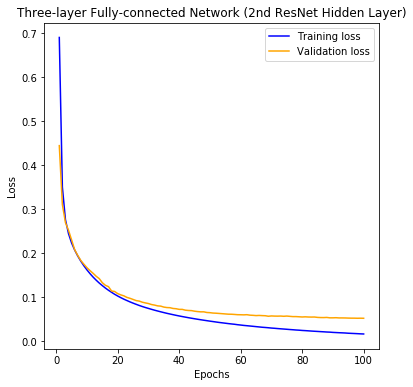

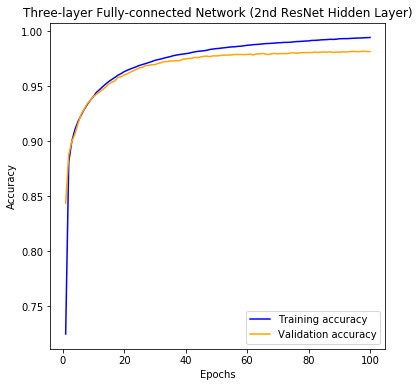

In [15]:
# Plot of Losses
history_dict_3 = history_3.history
loss_values_3 = history_dict_3['loss']
val_loss_values_3 = history_dict_3['val_loss']
acc_values_3 = history_dict_3['acc']
val_acc_values_3 = history_dict_3['val_acc']

epochs_index = range(1,len(loss_values_3)+1)
fig_loss_3 = plt.figure(figsize=(6, 6))
plt.plot(epochs_index, loss_values_3, 'b', label='Training loss')
plt.plot(epochs_index, val_loss_values_3, 'b', c='orange', label='Validation loss')
plt.title('Three-layer Fully-connected Network (2nd ResNet Hidden Layer)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Plot of Accuracies
fig_accuracy_3 = plt.figure(figsize=(6, 6))
plt.plot(epochs_index,acc_values_3,'b', label='Training accuracy')
plt.plot(epochs_index,val_acc_values_3,'b', c='orange', label='Validation accuracy')
plt.title('Three-layer Fully-connected Network (2nd ResNet Hidden Layer)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

## Save the Plots

In [16]:
fig_accuracy_3.savefig('fig_accuracy_3.eps', format='eps', dpi=2000)
fig_accuracy_3.savefig('fig_accuracy_3.pdf', format='pdf', dpi=2000)

# The Fourth Model (MLP) (Hinge Loss)

Input -> Fully Connected (2048) -> ReLU -> Fully Connected (2048) -> ReLU -> Fully Connected (2048) -> ReLU -> Fully Connected (10) -> Softmax -> Categorical hinge loss

In [17]:
# model
p0 = tf.keras.layers.Input(shape=(784,))
p1 = tf.keras.layers.Dense(2048, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(p0)
p2 = tf.keras.layers.Dense(2048, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(p1)
p3 = tf.keras.layers.Dense(2048, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(p2)
y_mlp_4 = tf.keras.layers.Dense(num_classes, activation=None, use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(p3)

model_4 = tf.keras.models.Model(inputs=p0, outputs=y_mlp_4)

model_4.summary()

sgd4 = tf.keras.optimizers.SGD(lr=0.05, decay=0, momentum=0, nesterov=False)
model_4.compile(loss='categorical_hinge', optimizer=sgd4, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 2048)              1607680   
_________________________________________________________________
dense_14 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_15 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_16 (Dense)             (None, 10)                20490     
Total params: 10,020,874
Trainable params: 10,020,874
Non-trainable params: 0
_________________________________________________________________


## Fit the Model using Back Propagation (Vanilla SGD)

In [18]:
history_4 = model_4.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    validation_data=(x_test, y_test),
                    shuffle=False)
score_4 = model_4.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score_4[0])
print('Test accuracy:', score_4[1])
#print('Test error:', 1-score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
 - 2s - loss: 1.0578 - acc: 0.4744 - val_loss: 0.9077 - val_acc: 0.7281
Epoch 2/100
 - 2s - loss: 0.7479 - acc: 0.7277 - val_loss: 0.6135 - val_acc: 0.7687
Epoch 3/100
 - 2s - loss: 0.4911 - acc: 0.8169 - val_loss: 0.4127 - val_acc: 0.8482
Epoch 4/100
 - 2s - loss: 0.3392 - acc: 0.8851 - val_loss: 0.3372 - val_acc: 0.8719
Epoch 5/100
 - 2s - loss: 0.2675 - acc: 0.9014 - val_loss: 0.2832 - val_acc: 0.8921
Epoch 6/100
 - 2s - loss: 0.2364 - acc: 0.9112 - val_loss: 0.2632 - val_acc: 0.8995
Epoch 7/100
 - 2s - loss: 0.2165 - acc: 0.9179 - val_loss: 0.2458 - val_acc: 0.9077
Epoch 8/100
 - 2s - loss: 0.2005 - acc: 0.9243 - val_loss: 0.2095 - val_acc: 0.9216
Epoch 9/100
 - 2s - loss: 0.1866 - acc: 0.9296 - val_loss: 0.1969 - val_acc: 0.9261
Epoch 10/100
 - 2s - loss: 0.1742 - acc: 0.9342 - val_loss: 0.1853 - val_acc: 0.9293
Epoch 11/100
 - 2s - loss: 0.1629 - acc: 0.9387 - val_loss: 0.1686 - val_acc: 0.9371
Epoch 12/100
 - 2s - los

Epoch 97/100
 - 2s - loss: 0.0029 - acc: 0.9991 - val_loss: 0.0479 - val_acc: 0.9810
Epoch 98/100
 - 2s - loss: 0.0028 - acc: 0.9992 - val_loss: 0.0481 - val_acc: 0.9815
Epoch 99/100
 - 2s - loss: 0.0026 - acc: 0.9992 - val_loss: 0.0477 - val_acc: 0.9816
Epoch 100/100
 - 2s - loss: 0.0025 - acc: 0.9992 - val_loss: 0.0485 - val_acc: 0.9810
Test loss: 0.04853608032464981
Test accuracy: 0.981


## Loss and Accuracy Plots

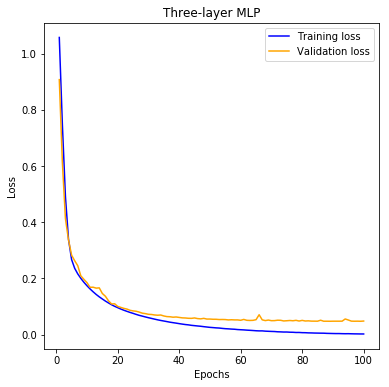

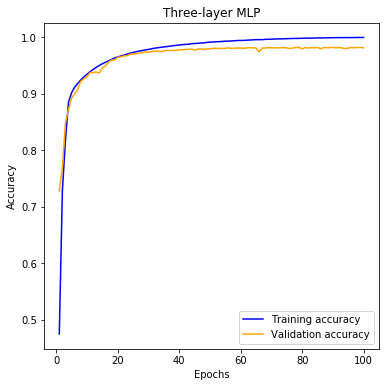

In [19]:
# Plot of Losses
history_dict_4 = history_4.history
loss_values_4 = history_dict_4['loss']
val_loss_values_4 = history_dict_4['val_loss']
acc_values_4 = history_dict_4['acc']
val_acc_values_4 = history_dict_4['val_acc']

epochs_index = range(1,len(loss_values_4)+1)
fig_loss_4 = plt.figure(figsize=(6, 6))
plt.plot(epochs_index, loss_values_4, 'b', label='Training loss')
plt.plot(epochs_index, val_loss_values_4, 'b', c='orange', label='Validation loss')
plt.title('Three-layer MLP')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Plot of Accuracies
fig_accuracy_4 = plt.figure(figsize=(6, 6))
plt.plot(epochs_index,acc_values_4,'b', label='Training accuracy')
plt.plot(epochs_index,val_acc_values_4,'b', c='orange', label='Validation accuracy')
plt.title('Three-layer MLP')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

## Save the Plots

In [20]:
fig_accuracy_4.savefig('fig_accuracy_4.eps', format='eps', dpi=2000)
fig_accuracy_4.savefig('fig_accuracy_4.pdf', format='pdf', dpi=2000)